In [1]:
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt

## Read database

In [2]:
dbfile = "os-sqlite3-data/database.db"
table_name = "searched_books"
query = f"SELECT * FROM {table_name}"
with sqlite3.connect(dbfile) as connection:
    df = pd.read_sql_query(query, connection)

In [3]:
df.columns

Index(['id', 'title', 'authors', 'is_found_a', 'is_found_b', 'search_count_a',
       'search_count_b', 'search_terms_a', 'search_terms_b',
       'search_begin_time_utc', 'found_time_utc_a', 'found_time_utc_b',
       'search_end_time_utc', 'uid'],
      dtype='object')

In [4]:
# Convert missing values and booleans
df.replace("undefined", None, inplace=True)
df[["is_found_a", "is_found_b"]] = df[["is_found_a", "is_found_b"]].replace(
    "true", True
)  # , inplace=True)
df[["is_found_a", "is_found_b"]] = df[["is_found_a", "is_found_b"]].replace(
    "false", False
)  # , inplace=True)

# Convert timestamps in string format to datetime
df["search_begin_time_utc"] = pd.to_datetime(df["search_begin_time_utc"])
df["search_end_time_utc"] = pd.to_datetime(df["search_end_time_utc"])
df["found_time_utc_a"] = pd.to_datetime(df["found_time_utc_a"])
df["found_time_utc_b"] = pd.to_datetime(df["found_time_utc_b"])

# Calculate durations in seconds
df["duration_to_find_a"] = (
    df["found_time_utc_a"] - df["search_begin_time_utc"]
).dt.total_seconds()
df["duration_to_find_b"] = (
    df["found_time_utc_b"] - df["search_begin_time_utc"]
).dt.total_seconds()
df["duration_to_proceed"] = (
    df["search_end_time_utc"] - df["search_begin_time_utc"]
).dt.total_seconds()

df.head()

,id,title,authors,is_found_a,is_found_b,search_count_a,search_count_b,search_terms_a,search_terms_b,search_begin_time_utc,found_time_utc_a,found_time_utc_b,search_end_time_utc,uid,duration_to_find_a,duration_to_find_b,duration_to_proceed
0,1,Päiväkirjani,"Mäkinen, Mikael",True,False,1,None,"ADHD,",None,2023-09-26 14:28:11.036000+00:00,2023-09-26 14:28:30.046000+00:00,NaT,2023-09-26 14:28:31.106000+00:00,b4b8a394-32cf-4a9e-bbc2-f924869ea454,19.01,NaN,20.070
1,2,Kipukynnys,"Rantala, Raija-Sinikka",True,True,1,1,"naiset,","naiset,",2023-09-26 14:28:46.116000+00:00,2023-09-26 14:29:00.776000+00:00,2023-09-26 14:29:03.649000+00:00,2023-09-26 14:29:05.668000+00:00,b4b8a394-32cf-4a9e-bbc2-f924869ea454,14.66,17.533,19.552
2,3,Sirimaan salaisuus,"Tervo, Mari-Pauliina",False,True,None,1,None,"mielikuvitus,",2023-09-26 14:29:35.999000+00:00,NaT,2023-09-26 14:29:46.157000+00:00,2023-09-26 14:29:58.749000+00:00,b4b8a394-32cf-4a9e-bbc2-f924869ea454,NaN,10.158,22.750
3,4,Ryhmä Hau: Pentupoppoo,"Martínez, Liliana",False,True,None,1,None,"harrastukset,",2023-09-26 14:30:17.406000+00:00,NaT,2023-09-26 14:30:26.157000+00:00,2023-09-26 14:30:30.281000+00:00,b4b8a394-32cf-4a9e-bbc2-f924869ea454,NaN,8.751,12.875
4,5,Kuolleen silmät ja muita kauhukertomuksia,"Waltari, Mika",False,True,None,2,None,"kauhukirjallisuus,",2023-09-26 14:31:30.185000+00:00,NaT,2023-09-26 14:31:57.792000+00:00,2023-09-26 14:32:53.090000+00:00,b4b8a394-32cf-4a9e-bbc2-f924869ea454,NaN,27.607,82.905


## Results

In [5]:
df[["uid", "title"]].nunique()

uid       2
title    20
dtype: int64

In [6]:
df[["is_found_a", "is_found_b", "search_count_a", "search_count_b"]].sum()

is_found_a        13
is_found_b        12
search_count_a    20
search_count_b    15
dtype: object

In [7]:
# search_count_X is the number of searches performed when a book is selected
df[
    [
        "is_found_a",
        "is_found_b",
        "search_count_a",
        "search_count_b",
        "duration_to_find_a",
        "duration_to_find_b",
    ]
].mean()

is_found_a                 0.65
is_found_b                  0.6
search_count_a         1.538462
search_count_b             1.25
duration_to_find_a    31.355385
duration_to_find_b    20.630833
dtype: object

AttributeError: 'DataFrame' object has no attribute 'labels_set'

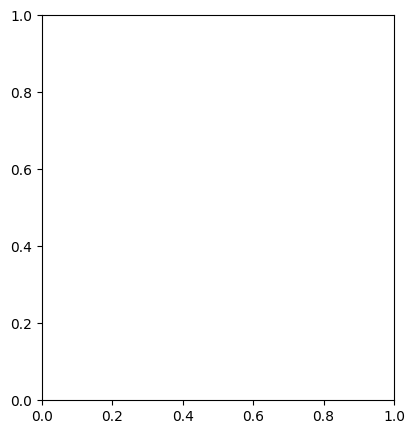

In [8]:
### TODO: Need adjust

# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
bins = list(range(0, 300, 20))

# Subplot for 'labels_set' == 'a'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df[df.labels_set == "a"].duration_to_find.hist()  # bins=bins)
plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Labels A")

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df[df.labels_set == "b"].duration_to_find.hist()  # bins=bins)
plt.xlabel("Search Duration (seconds)")
plt.ylabel("Searches")
plt.title("Labels B")

plt.suptitle("Histogram of duration of successful book searches")
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

AttributeError: 'DataFrame' object has no attribute 'labels_set'

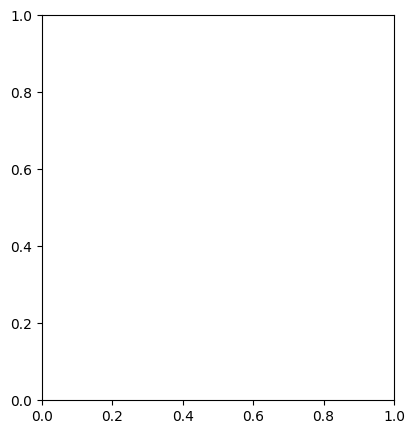

In [9]:
# Create a subplot with two histograms
plt.figure(figsize=(10, 5))  # Adjust the figure size as needed
# bins = list(range(0, 300, 20))

# Subplot for 'labels_set' == 'a'
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
df[(df.labels_set == "a")].search_count.hist()  # bins=bins)
df[(df.labels_set == "a") & (df.is_found)].search_count.hist()  # bins=bins)
plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.title("Labels A")

# Subplot for 'labels_set' == 'b'
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
df[df.labels_set == "b"].search_count.hist()  # bins=bins)
df[(df.labels_set == "b") & (df.is_found)].search_count.hist()  # bins=bins)
plt.xlabel("Search Count")
plt.ylabel("Searches")
plt.title("Labels B")

plt.suptitle("Histogram of search_count of book searches")
plt.tight_layout()  # Adjusts subplot parameters for better spacing
plt.show()

In [10]:
df.groupby(by="labels_set").agg(
    {
        "is_found": "mean",
        "duration_to_find": "mean",
        "duration_to_abandon": "mean",
    }
)

KeyError: 'labels_set'